In [1]:
import os
import sys
import importlib
import copy
import glob
import h5py
import json
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython.display as ipd

import util_figures
import util_signal
import util_cochlea
import util_network


2024-08-28 03:48:55.340767: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
list_dir_src = glob.glob("models/spkr_word_recognition/simplified_IHC3000/arch0_????")
for dir_src in list_dir_src:
    print(dir_src)
    with open(os.path.join(dir_src, "config.json"), "r") as f:
        CONFIG = json.load(f)
    with open(os.path.join(dir_src, "arch.json"), "r") as f:
        architecture = json.load(f)
    for d in architecture:
        if "pool" in d["layer_type"].lower():
            print(d["args"])


models/spkr_word_recognition/simplified_IHC3000/arch0_0000
{'name': 'block0_pool', 'padding': 'VALID_TIME', 'pool_size': [8, 16], 'sqrt_window': True, 'strides': [2, 4]}
{'name': 'block1_pool', 'padding': 'VALID_TIME', 'pool_size': [8, 16], 'sqrt_window': True, 'strides': [2, 4]}
{'name': 'block2_pool', 'padding': 'VALID_TIME', 'pool_size': [1, 16], 'sqrt_window': True, 'strides': [1, 4]}
{'name': 'block3_pool', 'padding': 'VALID_TIME', 'pool_size': [1, 16], 'sqrt_window': True, 'strides': [1, 4]}
{'name': 'block4_pool', 'padding': 'VALID_TIME', 'pool_size': [1, 1], 'sqrt_window': True, 'strides': [1, 1]}
{'name': 'block5_pool', 'padding': 'VALID_TIME', 'pool_size': [1, 1], 'sqrt_window': True, 'strides': [1, 1]}
{'name': 'block6_pool', 'padding': 'VALID_TIME', 'pool_size': [8, 16], 'sqrt_window': True, 'strides': [2, 4]}
models/spkr_word_recognition/simplified_IHC3000/arch0_0001
{'name': 'block0_pool', 'padding': 'VALID_TIME', 'pool_size': [8, 16], 'sqrt_window': True, 'strides': [2, 

In [6]:
list_dir_src = glob.glob("models/spkr_word_recognition/simplified_IHC????/arch0_????")
for dir_src in list_dir_src:
    dir_dst = dir_src.replace("spkr_word_recognition/simplified", "spkr_word_recognition/freq50mean_autocorr_block3input/simplified")
    if not os.path.exists(dir_dst):
        os.makedirs(dir_dst)
        print(f'"{dir_dst}"')
    with open(os.path.join(dir_src, "config.json"), "r") as f:
        CONFIG = json.load(f)
    with open(os.path.join(dir_src, "arch.json"), "r") as f:
        architecture_src = json.load(f)

    architecture_dst = []
    for d_src in architecture_src:
        d = dict(d_src)
        if "_pool" in d["args"]["name"]:
            if d["args"]["name"] in ["block0_pool", "block1_pool"]:
                d["args"]["pool_size"][0] = 1
                d["args"]["strides"][0] = 1
            if d["args"]["name"] in ["block3_pool", "block4_pool"]:
                d["args"]["pool_size"][0] = 8
                d["args"]["strides"][0] = 2
        if d["args"]["name"] == "block3_conv":
            if "concat" in dir_dst:
                d_autocorr = {
                    "layer_type": "AutocorrelationCorrelogram",
                    "args": {
                        "concat": True,
                        "name": "block3_autocorr",
                        "len_frame": 512,
                        "freq_pool": None,
                        "channel_mode": "mean",
                        "one_sided": True,
                    }
                }
            else:
                architecture_dst = architecture_dst[:1]
                d_autocorr = {
                    "layer_type": "AutocorrelationCorrelogram",
                    "args": {
                        "concat": False,
                        "name": "block3_autocorr",
                        "num_frame": 305,
                        "len_frame": 512,
                        "freq_pool": None,
                        "channel_mode": "mean",
                        "one_sided": True,
                    }
                }
            architecture_dst.append(d_autocorr)
        architecture_dst.append(d)

    with open(os.path.join(dir_dst, "config.json"), "w") as f:
        json.dump(CONFIG, f, indent=4, sort_keys=True)
    with open(os.path.join(dir_dst, "arch.json"), "w") as f:
        json.dump(architecture_dst, f, indent=4, sort_keys=True)


"models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC0050/arch0_0000"
"models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC0050/arch0_0001"
"models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC0050/arch0_0002"
"models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC0050/arch0_0004"
"models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC0050/arch0_0006"
"models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC0050/arch0_0007"
"models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC0050/arch0_0008"
"models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC0050/arch0_0009"
"models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC0050/arch0_0016"
"models/spkr_word_recognition/freq50mean_autocorr_block3input/simplified_IHC0050/arch0_0017"
"models/spkr_word_recognition/freq50mean_autocorr_block3input/simplifi

In [6]:
importlib.reload(util_network)

layer = util_network.AutocorrelationCorrelogram(channel_mode="mean", one_sided=1, freq_pool=4)

x = tf.zeros((1, 50, 20000, 3))
y = tf.zeros((1, 13, 300, 3))
z = layer((x, y))


tf.compat.v1.reset_default_graph()
z.shape


TensorShape([1, 13, 300, 259])

In [12]:
"""
Specify model directory and load config / architecture
"""
tf.compat.v1.reset_default_graph()

dir_model = "models/spkr_word_recognition/autocorr_block3input/simplified_IHC0050/arch0_0000"

fn_config = os.path.join(dir_model, "config.json")
fn_arch = os.path.join(dir_model, "arch.json")
fn_ckpt = os.path.join(dir_model, "ckpt_BEST")

with open(fn_config, "r") as f_config:
    CONFIG = json.load(f_config)
with open(fn_arch, "r") as f_arch:
    list_layer_dict = json.load(f_arch)
n_classes_dict = CONFIG["n_classes_dict"]

if CONFIG.get("kwargs_cochlea", {}):
    sr = CONFIG["kwargs_cochlea"]["sr_input"]
    if "localization" in dir_model:
        input_shape = [int(1.3 * sr), 2] # 1.3-second binaural input for localization model
    else:
        input_shape = [int(2 * sr)] # 2-second monaural input for word + voice recognition model
else:
    if "localization" in dir_model:
        input_shape = [50, 10000, 3, 2] # Pre-generated nervegram (50 freq channels, 1-second at 10 kHz, 3 spont rates, binaural)
    else:
        input_shape = [50, 20000, 3] # Pre-generated nervegram (50 freq channels, 2-seconds at 10 kHz, 3 spont rates, monaural)

print(f"Model input shape: {input_shape}")
print(f"Model output shape(s): {n_classes_dict}")


Model input shape: [40000]
Model output shape(s): {'label_speaker_int': 433, 'label_word_int': 794}


In [13]:
"""
Build TensorFlow model object and load pre-trained weights
"""
import importlib
importlib.reload(util_cochlea)
importlib.reload(util_network)


def model_io_function(x):
    y = x
    if CONFIG.get("kwargs_cochlea", {}):
        if "label_loc_int" in n_classes_dict:
            msg = "expected [batch, freq, time, spont, channel=2] or [batch, time, channel=2]"
            assert (len(y.shape) in [3, 5]) and (y.shape[-1] == 2), msg
            y0, _ = util_cochlea.cochlea(y[..., 0], **copy.deepcopy(CONFIG["kwargs_cochlea"]))
            y1, _ = util_cochlea.cochlea(y[..., 1], **copy.deepcopy(CONFIG["kwargs_cochlea"]))
            y = tf.concat([y0, y1], axis=-1)
            if y.shape[2] > nervegram_slice_length:
                y = util_cochlea.random_slice(
                    y,
                    slice_length=nervegram_slice_length,
                    axis=2, # Time axis
                    buffer=500)
        else:
            y, _ = util_cochlea.cochlea(y, **copy.deepcopy(CONFIG["kwargs_cochlea"]))
    y, _ = util_network.build_network(y, list_layer_dict[:2], n_classes_dict=n_classes_dict)
    return y

inputs = tf.keras.Input(shape=input_shape, batch_size=None, dtype=tf.float32)
model = tf.keras.Model(inputs=inputs, outputs=model_io_function(inputs))
# model.load_weights(fn_ckpt)
model.summary()


[cochlea] converting audio to subbands using fir_gammatone_filterbank
[cochlea] half-wave rectified subbands
[tf_fir_resample] interpreted `tensor_input.shape` as [batch, freq=50, time=40000]
[tf_fir_resample] `kwargs_fir_lowpass_filter`: {'cutoff': 50, 'fir_dur': 0.05, 'ihc_filter': True, 'order': 7}
[fir_lowpass_filter] sr_filt = 20000.0 Hz
[fir_lowpass_filter] numtaps = 1001 samples
[fir_lowpass_filter] fir_dur = 0.05 seconds
[fir_lowpass_filter] cutoff = 50 Hz
[fir_lowpass_filter] order = 7 (bez2018model IHC filter)
[cochlea] resampled subbands from 20000 Hz to 10000 Hz with filter: {'cutoff': 50, 'fir_dur': 0.05, 'ihc_filter': True, 'order': 7}
[cochlea] half-wave rectified resampled subbands
[cochlea] incorporated sigmoid_rate_level_function: {'dynamic_range': [20.0, 40.0, 80.0], 'dynamic_range_interval': 0.95, 'envelope_mode': True, 'rate_max': [250.0, 250.0, 250.0], 'rate_spont': [0.0, 0.0, 0.0], 'threshold': [0.0, 12.0, 28.0]}
[cochlea] inferring `sr=10000.0` for spike_generat

In [14]:
"""
Load stimuli on which to evaluate model
"""

fn_stim = "stimuli/spkr_word_recognition/evaluation/human_experiment_v00_foreground60dbspl/stim.hdf5"
with h5py.File(fn_stim, "r") as f:
    batch_size = 8
    idx0 = -12
    indexes = slice(idx0, idx0 + batch_size)
    y = f["signal"][indexes]
    print(f"Batch of example inputs: {y.shape=} {y.dtype=}")
    for k in f.keys():
        if f[k].ndim == 1:
            print("|__", k, f[k].dtype, f[k][indexes])


Batch of example inputs: y.shape=(8, 40000) y.dtype=dtype('float32')
|__ STRAIGHT_FLAG int64 [-1 -1 -1 -1 -1 -1 -1 -1]
|__ background_condition int64 [4 4 4 4 4 4 4 4]
|__ background_index int64 [375 375 375 375 375 375 375 375]
|__ dbspl float64 [72.33881102 69.61217855 67.09641827 64.90902051 63.16353509 61.90902001
 61.09641871 60.61217781]
|__ decoding_dict_background_source_file object []
|__ decoding_dict_foreground_source_file object []
|__ foreground_dbspl float64 [60. 60. 60. 60. 60. 60. 60. 60.]
|__ foreground_index int64 [375 375 375 375 375 375 375 375]
|__ index int64 [28188 28189 28190 28191 28192 28193 28194 28195]
|__ label_speaker_int int64 [259 259 259 259 259 259 259 259]
|__ label_word_int int64 [791 791 791 791 791 791 791 791]
|__ snr float32 [-12.  -9.  -6.  -3.   0.   3.   6.   9.]
|__ sr int64 [20000 20000 20000 20000 20000 20000 20000 20000]


In [15]:
# """
# Evaluate model on example stimuli
# """

# out = model(y)

# print("Model outputs (softmax cross entropy logits):")
# for k, v in out.items():
#     print("|__", k, v.dtype, v.shape)

# print("Model outputs (class label predictions):")
# for k, v in out.items():
#     print("|__", k, np.argmax(v, axis=1))


In [16]:
nervegram = model(y)
nervegram.shape


TensorShape([8, 50, 305, 768])

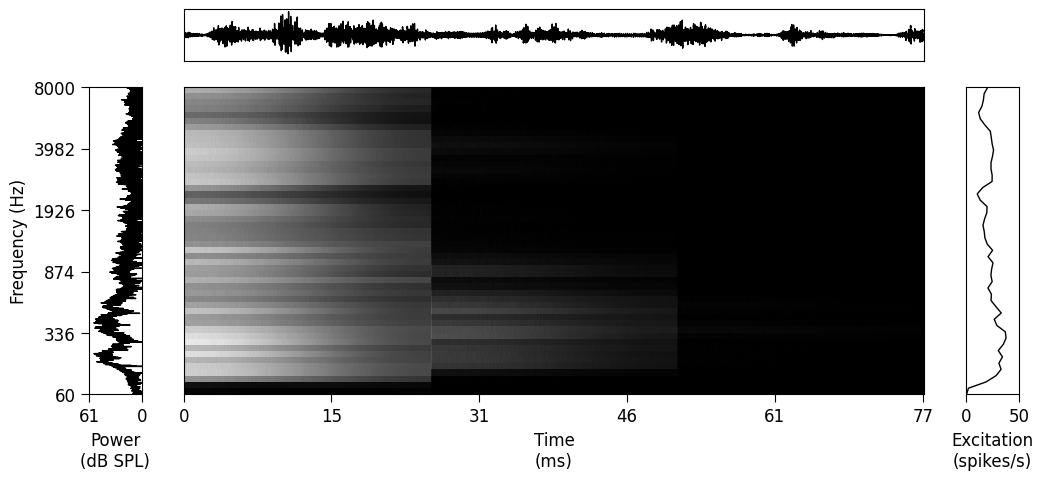

In [17]:
nervegram_to_plot = nervegram[-1, :, 200, 0:].numpy()
# nervegram_to_plot = nervegram_to_plot.reshape([nervegram_to_plot.shape[0], 3, -1])[:, 0, :]
waveform_to_plot = y[0]
cfs = util_signal.erbspace(60.0, 8000.0, 50)
sr = 20000
sr_nervegram = 10000

figsize = (12, 5)
nrows = 2
ncols = 3
gridspec_kw = {
    "wspace": 0.15,
    "hspace": 0.15,
    "width_ratios": [1, 14, 1],
    "height_ratios": [1, 6],
}
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
util_figures.make_stimulus_summary_plot(
    ax_arr,
    ax_idx_waveform=1,
    ax_idx_spectrum=3,
    ax_idx_nervegram=4,
    ax_idx_excitation=5,
    waveform=waveform_to_plot,
    nervegram=nervegram_to_plot,
    sr_waveform=sr,
    sr_nervegram=sr_nervegram,
    cfs=cfs,
    # tmin=0.5,
    # tmax=0.5 + 0.05 * 5,
    interpolation="none")
plt.show()


In [16]:
# list_dir_model = glob.glob("models/sound_localization/autocorr_???sided/simplified_IHC????_delayed_integration/arch*")

# for dir_model in list_dir_model:
#     fn_config = os.path.join(dir_model, "config.json")
#     with open(fn_config, "r") as f_config:
#         CONFIG = json.load(f_config)
#     CONFIG["kwargs_cochlea"]["kwargs_autocorrelation_correlogram"] = {
#         "dur_frame": 0.05,
#         "overlap": 0.5 if "onesided" in dir_model else 0.0,
#         "one_sided": True if "onesided" in dir_model else False,
#         "concat_axis": -1,
#     }
#     if "sound_localization" in dir_model:
#         CONFIG["kwargs_dataset_from_tfrecords"]["features_to_exclude"] = [
#             "nervegram_meanrates",
#             "list_background_index_brir",
#         ]
#     with open(fn_config, "w") as f_config:
#         json.dump(CONFIG, f_config, indent=4, sort_keys=True)
#     print(f'"{dir_model}"')


In [9]:
import os
import sys
import copy
import glob
import h5py
import json

import util
import util_bez2018model
import util_tfrecords


BASE_CONFIG = {
    'examples_per_tfrecord_fin': 100000,
    'examples_per_tfrecord_tmp': 2000,
    'compression_type': 'GZIP',
    'disp_step': 100,
    'kwargs_ExampleProcessor': {
        'kwargs_nervegram': {
            'nervegram_dur': None,
            'nervegram_dtype': 'float16',
            'nervegram_fs': 10e3,
            'buffer_start_dur': 0.0,
            'buffer_end_dur': 0.0,
            'pin_fs': 100e3,
            'pin_dBSPL_flag': 0,
            'pin_dBSPL': None,
            'species': 2,
            'bandwidth_scale_factor': 1.0,
            'cf_list': None,
            'num_cf': 1,
            'min_cf': 125,
            'max_cf': 8e3,
            'max_spikes_per_train': 1000,
            'num_spike_trains': 1,
            'cohc': 1.0,
            'cihc': 1.0,
            'IhcLowPass_cutoff': 3000,
            'IhcLowPass_order': 7,
            'spont': [70.0],
            'noiseType': 1,
            'implnt': 0,
            'tabs': 6e-4,
            'trel': 6e-4,
            'synapseMode': 0,
            'random_seed': None,
            'return_vihcs': False,
            'return_meanrates': True,
            'return_spike_times': False,
            'return_spike_tensor_sparse': False,
            'return_spike_tensor_dense': False,
            'nervegram_spike_tensor_fs': 100e3,
            'squeeze_spont_dim': True,
            'squeeze_channel_dim': True,
        },
        'key_signal_fs': '/sources/signal/sr',
        'key_signal': '/stimuli/signal',
        'key_noise': None,
        'key_snr': None,
        'key_dbspl': None,
        'range_snr': None,
        'range_dbspl': [30.0, 90.0],
        'list_keys_to_copy': [
            ["/augment_STRAIGHT_f0_shift", "augment_STRAIGHT_f0_shift"],
            ["/augment_STRAIGHT_whisper", "augment_STRAIGHT_whisper"],
            ["/sources/noise/labels_binary_via_int", "label_audioset_multihot"],
            ["/sources/signal/speaker_int", "label_speaker_int"],
            ["/sources/signal/word_int", "label_word_int"],
            ['/sources/noise/snr', 'snr'],
        ],
        'list_keys_to_ignore': [
            'pin'
        ],
    }
}

list_dir_stim = [
    'stimuli/spkr_word_recognition/optimization/train',
    'stimuli/spkr_word_recognition/optimization/valid',
    'stimuli/spkr_word_recognition/evaluation/hopkins_moore_2009',
    'stimuli/spkr_word_recognition/evaluation/human_experiment_v00_foreground60dbspl',
    'stimuli/spkr_word_recognition/evaluation/human_experiment_v00_inharmonic_foreground60dbspl',
    'stimuli/spkr_word_recognition/evaluation/pitch_altered_v00',
    'stimuli/spkr_word_recognition/evaluation/speech_in_synthetic_textures',
]

for dir_stim in list_dir_stim:
    fn_src = glob.glob(os.path.join(dir_stim, '*.hdf5'))[0]
    CONFIG = copy.deepcopy(BASE_CONFIG)
    print('\n' + fn_src)
    if 'evaluation' in fn_src:
        CONFIG['kwargs_ExampleProcessor']['key_signal'] = 'signal'
        CONFIG['kwargs_ExampleProcessor']['key_signal_fs'] = 'sr'
        CONFIG['kwargs_ExampleProcessor']['range_dbspl'] = None
        CONFIG['kwargs_ExampleProcessor']['list_keys_to_copy'] = []
        with h5py.File(fn_src, 'r') as f_src:
            for k in util.get_hdf5_dataset_key_list(f_src):
                skip_list = [
                    'foreground_wav',
                    'foreground_wav_clip_pos',
                    'background_wav',
                    'background_wav_clip_pos',
                    'signal',
                    'background_signal',
                    'foreground_signal',
                ]
                if (k not in skip_list) and (f_src[k].shape[0] == f_src['signal'].shape[0]):
                    CONFIG['kwargs_ExampleProcessor']['list_keys_to_copy'].append(k)
                    assert len(f_src[k].shape) == 1

    dir_nervegram = os.path.join(dir_stim, 'tfrecords_simplified')
    fn_config = os.path.join(dir_nervegram, 'config.json')
    if not os.path.exists(dir_nervegram):
        os.mkdir(dir_nervegram)
        print(dir_nervegram)
    example_processor = util_bez2018model.ExampleProcessor(
        fn_src,
        idx_start=0,
        idx_end=100,
        random_seed=0,
        **CONFIG['kwargs_ExampleProcessor'])
    example = example_processor.process_example(0)
    feature_description, bytes_description = util_tfrecords.get_description_from_example(example)
    example_processor.close()
    CONFIG['feature_description'] = feature_description
    CONFIG['bytes_description'] = bytes_description
    util_bez2018model.write_config(dir_nervegram, CONFIG)



stimuli/spkr_word_recognition/optimization/train/JSIN_all__run_000_DZKGBOFKNVV2SVR5ZNV7KC5TRMD6P5ZJ.hdf5
###### EXAMPLE STRUCTURE ######
## augment_STRAIGHT_f0_shift float32 () -1.0
## augment_STRAIGHT_whisper float32 () 0.0
## dbspl float64 () 62.92881023563949
## label_audioset_multihot int64 (517,) 4136
## label_speaker_int int64 () 385
## label_word_int int64 () 28
## nervegram_meanrates float16 (1, 20000, 1) 40000
## signal float32 (40000,) 160000
## signal_fs int64 () 20000
## snr float64 () 2.0
###### EXAMPLE STRUCTURE ######
[WROTE CONFIG] stimuli/spkr_word_recognition/optimization/train/tfrecords_simplified/config_feature_description.pkl
[WROTE CONFIG] stimuli/spkr_word_recognition/optimization/train/tfrecords_simplified/config_bytes_description.pkl
[WROTE CONFIG] stimuli/spkr_word_recognition/optimization/train/tfrecords_simplified/config.json

stimuli/spkr_word_recognition/optimization/valid/JSIN_all__run_000_RQTTZB4C3TJJVLJUWDV72TYMC7S4MNHH.hdf5
###### EXAMPLE STRUCTURE ##

In [8]:
BASE_CONFIG = {
    'examples_per_tfrecord_fin': 100000,
    'examples_per_tfrecord_tmp': 2000,
    'compression_type': 'GZIP',
    'disp_step': 100,
    'kwargs_ExampleProcessor': {
        'kwargs_nervegram': {
            'nervegram_dur': 1.3,
            'nervegram_dtype': 'float16',
            'nervegram_fs': 10e3,
            'buffer_start_dur': 0.07,
            'buffer_end_dur': 0.01,
            'pin_fs': 100e3,
            'pin_dBSPL_flag': 0,
            'pin_dBSPL': None,
            'species': 2,
            'bandwidth_scale_factor': 1.0,
            'cf_list': None,
            'num_cf': 1,
            'min_cf': 125,
            'max_cf': 16e3,
            'max_spikes_per_train': 1000,
            'num_spike_trains': 1,
            'cohc': 1.0,
            'cihc': 1.0,
            'IhcLowPass_cutoff': 3000,
            'IhcLowPass_order': 7,
            'spont': [70.0],
            'noiseType': 0,
            'implnt': 0,
            'tabs': 6e-4,
            'trel': 6e-4,
            'synapseMode': 0,
            'random_seed': None,
            'return_vihcs': False,
            'return_meanrates': True,
            'return_spike_times': False,
            'return_spike_tensor_sparse': False,
            'return_spike_tensor_dense': False,
            'nervegram_spike_tensor_fs': 100e3,
        },
        'key_signal_fs': 'sr',
        'key_signal': 'signal',
        'key_noise': None,
        'key_snr': None,
        'key_dbspl': None,
        'range_snr': None,
        'range_dbspl': None,
        'list_keys_to_copy': [],
        'list_keys_to_ignore': [
            'pin'
        ],
    }
}

list_dir_stim = [
    'stimuli/sound_localization/optimization/train',
    'stimuli/sound_localization/optimization/valid',
    'stimuli/sound_localization/evaluation/bandwidth_dependency',
    'stimuli/sound_localization/evaluation/itd_ild_weighting',
    'stimuli/sound_localization/evaluation/itd_threshold',
    'stimuli/sound_localization/evaluation/minimum_audible_angle_interpolated',
    'stimuli/sound_localization/evaluation/mp_spectral_cues',
    'stimuli/sound_localization/evaluation/new_ears',
    'stimuli/sound_localization/evaluation/precedence_effect_localization',
    'stimuli/sound_localization/evaluation/spectral_smoothing',
    'stimuli/sound_localization/evaluation/speech_in_noise_in_reverb_v04',
    'stimuli/sound_localization/evaluation/v01_eval_mit_bldg46room1004_tenoise',
]

for dir_stim in list_dir_stim:
    fn_src = glob.glob(os.path.join(dir_stim, '*.hdf5'))[0]
    CONFIG = copy.deepcopy(BASE_CONFIG)
    print('\n' + fn_src)
    with h5py.File(fn_src, 'r') as f_src:
        if f_src['signal'].shape[1] > 61740:
            CONFIG['kwargs_ExampleProcessor']['sample_start'] = int(0.28 * 44e3)
            CONFIG['kwargs_ExampleProcessor']['sample_end'] = int((0.28 + 1.40) * 44e3)
            CONFIG['kwargs_ExampleProcessor']['kwargs_nervegram']['nervegram_dur'] = 1.3
        elif f_src['signal'].shape[1] == 44100:
            CONFIG['kwargs_ExampleProcessor']['kwargs_nervegram']['nervegram_dur'] = 1.0
        for k in util.get_hdf5_dataset_key_list(f_src):
            skip_list = [
                'foreground_wav',
                'foreground_wav_clip_pos',
                'background_wav',
                'background_wav_clip_pos',
                'signal',
                'background_signal',
                'foreground_signal',
            ]
            if (k not in skip_list) and (f_src[k].shape[0] == f_src['signal'].shape[0]):
                CONFIG['kwargs_ExampleProcessor']['list_keys_to_copy'].append(k)
                assert len(f_src[k].shape) == 1

        dir_nervegram = os.path.join(dir_stim, 'tfrecords_simplified')
        fn_config = os.path.join(dir_nervegram, 'config.json')
        if not os.path.exists(dir_nervegram):
            os.mkdir(dir_nervegram)
            print(dir_nervegram)
        example_processor = util_bez2018model.ExampleProcessor(
            fn_src,
            idx_start=0,
            idx_end=100,
            random_seed=0,
            **CONFIG['kwargs_ExampleProcessor'])
        example = example_processor.process_example(0)
        feature_description, bytes_description = util_tfrecords.get_description_from_example(example)
        example_processor.close()
        CONFIG['feature_description'] = feature_description
        CONFIG['bytes_description'] = bytes_description
        util_bez2018model.write_config(dir_nervegram, CONFIG)



stimuli/sound_localization/optimization/train/stim_0000000_0009071.hdf5
###### EXAMPLE STRUCTURE ######
## dbspl float32 () 62.92881
## flag_complete int64 () 1
## foreground_azim int64 () 80
## foreground_dist float32 () 1.4
## foreground_elev int64 () 20
## foreground_index_brir int64 () 182
## index int64 () 0
## index_background int64 () 26281
## index_foreground int64 () 4908
## index_room int64 () 1484
## len_list_background_index_brir int64 () 7
## list_background_index_brir int64 (7,) [1017  229   70 1514 1153  510  631]
## n_loc_background int64 () 7
## n_loc_foreground int64 () 1
## nervegram_meanrates float16 (1, 13000, 1, 2) 52000
## signal float32 (57330, 2) 458640
## signal_fs int64 () 44100
## snr float32 () 2.3158484
## split_int int64 () 0
## sr int64 () 44100
###### EXAMPLE STRUCTURE ######
[WROTE CONFIG] stimuli/sound_localization/optimization/train/tfrecords_simplified/config_feature_description.pkl
[WROTE CONFIG] stimuli/sound_localization/optimization/train/tfrec